# 三角形绘制

> 本章节算法和代码引用了  Dmitry V. Sokolov 的 [tinyrenderer](https://github.com/ssloy/tinyrenderer) 第二章三角形光栅化过程。在原算法的基础上，本章节做了整理、改进和重构。感谢 Dmitry V. Sokolov 将这一段算法整理成册，并开源地发布在 GitHub 供所有人使用。

在上一章节中，我们描述了基本的线段绘制的算法。线段是所有直线，射线，以及曲线的基本构成单元。对于一条曲线来说，我们可以通过利用微积分的思想，将曲线转换为一条一条细小的线段，通过控制线段的数量来控制曲线的平滑精度。而对于一个曲面来说，我们则可以通过渲染无数个细小的三角形来拟合。

我们在此章节中，将会探索在 2D 平面下的三角形渲染。在掌握了 2D 三角形渲染的方法以后，对于一个立体的 3D 图形，无非通过投影变换将三维空间转换为二维平面，然后重复这个渲染过程。

In [1]:
%%capture

# 执行第二章的代码，引入 draw_line 函数
%run "02-line.ipynb"

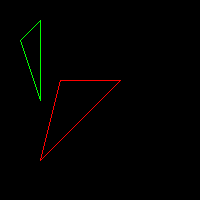

In [2]:
def draw_triangle_frame(img, p1, p2, p3, color):
  draw_line(img, p1, p2, color)
  draw_line(img, p2, p3, color)
  draw_line(img, p3, p1, color)

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_triangle_frame(img, (0.2, 0.2), (0.6, 0.6), (0.3, 0.6), (255, 0, 0, 255))
draw_triangle_frame(img, (0.2, 0.5), (0.1, 0.8), (0.2, 0.9), (0, 255, 0, 255))
display(img)

运行该程序我们就可以得到一个空心三角形。

## 扫描线算法

通过线段绘制的办法，我们已经得到了一个空心的三角形。而对于实心三角形来说，一个朴素的想法是，我们从下至上，如同填色一样，一条线一条线的补全颜色，直到绘制完成整个三角形。

由于我们不断的在三角形内部从左至右扫描并填，这个算法被称之为扫描线算法。现在让我们来讨论扫描线算法的实现细节。

第一步，我们将三角形切分为上下两部分。

![Split Triangle](assets/03-triangle/split-triangle.png)

如上图所示，红色的三角形被经过B点的水平线，分成了上下两部分。上部分三角形由线段 AC，BC 和水平线 BD 围成，下半部分三角形则由 AC，AB 和水平线BD围成。A，B，C 三点的确定只需要根据三角形的三个端点的 y 坐标从低到高排序即可。

如果 A 和 B 处于同一水平线，y 值相等，那么我们可以认为其下半部分 ABD（或上半部分 BDC ）为空三角形，而只存在上半部分（或下半部分）三角形。

经过如此切分以后，三角形的三条线段的方程都是已知的。那么我们关注三角形 ABD，我们下往上，在线段 AD 上寻找一个点，然后做水平线，与 AB 相交，这条线段即我们的扫描线。这根扫描线明显处于三角形内部，那么我们把其经过的所有像素着色即可。


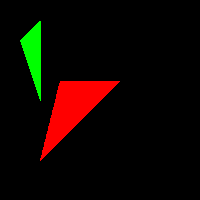

In [3]:
# 已知线段的两个端点，当一个点在线段上，并已知其y值，求x值
def solve_line_x(p1, p2, y):
    # p1.y和p2.y应不相等，我们在扫描线循环中，规避了相等情况
    assert p1[1] != p2[1]
    t = (y - p1[1]) / (p2[1] - p1[1])
    return t * (p2[0] - p1[0]) + p1[0]

def draw_triangle(img, p1, p2, p3, color):
    # 将屏幕坐标转换到像素空间
    p1i = (round(p1[0] * img.size[0]), round(p1[1] * img.size[1]))
    p2i = (round(p2[0] * img.size[0]), round(p2[1] * img.size[1]))
    p3i = (round(p3[0] * img.size[0]), round(p3[1] * img.size[1]))
    
    # 将三角形三个坐标按y轴从低到高排序
    if p1i[1] > p2i[1]:
        p1i, p2i = p2i, p1i
    if p1i[1] > p3i[1]:
        p1i, p3i = p3i, p1i
    if p2i[1] > p3i[1]:
        p2i, p3i = p3i, p2i
    
    # 扫描下半部分三角形，如果三角形水平，p1i.y == p2i.y, 则该循环被跳过
    for y in range(p1i[1], p2i[1]):
        x_min = solve_line_x(p1i, p3i, y) / img.size[0]
        x_max = solve_line_x(p1i, p2i, y) / img.size[0]
        y = y / img.size[1]
        draw_line(img, (x_min, y), (x_max, y), color)
    
    # 扫描上半部分三角形，如果三角形水平，p2i.y == p3i.y, 则该循环被跳过
    for y in range(p2i[1], p3i[1]):
        x_min = solve_line_x(p1i, p3i, y) / img.size[0]
        x_max = solve_line_x(p2i, p3i, y) / img.size[0]
        y = y / img.size[1]
        draw_line(img, (x_min, y), (x_max, y), color)

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_triangle(img, (0.2, 0.2), (0.6, 0.6), (0.3, 0.6), (255, 0, 0, 255))
draw_triangle(img, (0.2, 0.5), (0.1, 0.8), (0.2, 0.9), (0, 255, 0, 255))
display(img)

## 包围盒测试算法

扫描线算法是一个非常老牌的算法，其不仅用于三角形绘制，同时还被大量应用于计算几何中。扫描线算法被大量应用于曾经的单线程 CPU 架构中，然而随着 GPU 的发展，带来了数千 GPU 线程同时绘制图形的方案，一个更适合多线程的包围盒测试算法应运而生。

我们用一张图片来解释包围盒测试：

![Bounding Box](assets/03-triangle/bounding-box.png)

如图所示，绿色的长方形是红色三角形的包围盒。包围盒是这样一个长方形，其长和宽于`x`轴和`y`轴平行，并且其刚刚好围住了内部的三角形。很显然，包围盒的最小或最大`x`值是三角形三个端点中最小或最大的`x`，同理`y`也是如此。

如果一个点处于包围盒之外，很显然它一定处于三角形之外。而一个处于包围盒之内的点，则有可能出现在三角形之内（B 点），或出现在三角形之外（A 点）。

因此，我们仅仅只需遍历包围盒中的所有像素，并测试其是否在三角形之内，如果之内，则着色，否则则跳过该像素。

首先我们来绘制包围盒子：

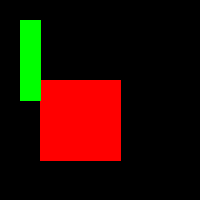

In [4]:
def is_in_triangle(p1, p2, p3, p):
    # 因为我们要绘制包围盒，所以我们姑且认为包围盒中的点都属于三角形
    return True

def draw_triangle(img, p1, p2, p3, color):
    # 将屏幕坐标转换到像素空间
    p1i = (round(p1[0] * img.size[0]), round(p1[1] * img.size[1]))
    p2i = (round(p2[0] * img.size[0]), round(p2[1] * img.size[1]))
    p3i = (round(p3[0] * img.size[0]), round(p3[1] * img.size[1]))
    
    # 找到包围盒左下和右上两个端点
    p_min = (min(p1i[0], p2i[0], p3i[0]), min(p1i[1], p2i[1], p3i[1]))
    p_max = (max(p1i[0], p2i[0], p3i[0]), max(p1i[1], p2i[1], p3i[1]))
    
    for x in range(p_min[0], p_max[0]+1):
        for y in range(p_min[1], p_max[1]+1):
            p = (x / img.size[0], y / img.size[1])
            if is_in_triangle(p1, p2, p3, p):
                img.putpixel((x, img.size[1]-y), color)

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_triangle(img, (0.2, 0.2), (0.6, 0.6), (0.3, 0.6), (255, 0, 0, 255))
draw_triangle(img, (0.2, 0.5), (0.1, 0.8), (0.2, 0.9), (0, 255, 0, 255))
display(img)

上诉代码成功绘制了绿色三角形和红色三角形的包围盒。现在我们来实现`is_in_triangle`算法，测试属于包围盒的点，是否同时也属于三角形。

在这里我们引入重心坐标系。在数学中，重心坐标是由单形（如三角形或四面体等）顶点定义的坐标。重心坐标是齐次坐标的一种。

假设三角形的三个顶点为 $A$, $B$, $C$。那么点 $P$ 可以表示为：

$$
P = iA + uB + vC, \text{where $i + u + v = 1$}
$$

则 $(i, u, v)$ 为点 $P$ 的重心坐标。并且如果 $i$, $u$, $v$ 其中任何一个值小于 0，那么点 $P$ 则落在三角形外部。

我们令 $i=1-u-v$ , 则

$$
\begin{equation}
\begin{aligned}
P &= (1-u-v)A + uB + vC \\
  &= A - uA - vA + uB + vC \\
  &= A + u\overrightarrow{AB} + v\overrightarrow{AC}
\end{aligned}
\end{equation}
$$

整理可得

$$
u\overrightarrow{AB} + v\overrightarrow{AC} + \overrightarrow{PA} = \overrightarrow{0}
$$

我们把坐标进行分解，并且用矩阵表示则有

$$
\begin{cases}
\begin{bmatrix}u, v, 1\end{bmatrix} \cdot \begin{bmatrix}\overrightarrow{AB}_x \cr \overrightarrow{AC}_x \cr \overrightarrow{PA}_x\end{bmatrix} = 0 \\
\begin{bmatrix}u, v, 1\end{bmatrix} \cdot \begin{bmatrix}\overrightarrow{AB}_y \cr \overrightarrow{AC}_y \cr \overrightarrow{PA}_y\end{bmatrix} = 0
\end{cases}
$$

一个有趣的事实是，向量 $(u, v, 1)$ 同时与两个向量垂直（内积为 0），很显然，向量 $(u, v, 1)$ 与这两个向量的叉积（Cross Product）平行。

我们用`numpy`来帮助我们计算向量的叉积：

In [5]:
import numpy as np

def is_in_triangle(a, b, c, p):
    v1 = np.array([b[0]-a[0], c[0]-a[0], a[0]-p[0]])
    v2 = np.array([b[1]-a[1], c[1]-a[1], a[1]-p[1]])
    v3 = np.cross(v1, v2)
    # 将最后一位设为1
    v3 /= v3[2]
    i, u, v = 1-v3[0]-v3[1], v3[0], v3[1]
    return not(i < 0 or u < 0 or v < 0)

将这一段测试函数和原先的绘制函数组合一起则有：

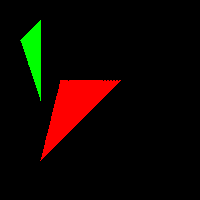

In [6]:
def draw_triangle(img, p1, p2, p3, color):
    # 将屏幕坐标转换到像素空间
    p1i = (round(p1[0] * img.size[0]), round(p1[1] * img.size[1]))
    p2i = (round(p2[0] * img.size[0]), round(p2[1] * img.size[1]))
    p3i = (round(p3[0] * img.size[0]), round(p3[1] * img.size[1]))
    
    # 找到包围盒左下和右上两个端点
    p_min = (min(p1i[0], p2i[0], p3i[0]), min(p1i[1], p2i[1], p3i[1]))
    p_max = (max(p1i[0], p2i[0], p3i[0]), max(p1i[1], p2i[1], p3i[1]))
    
    for x in range(p_min[0], p_max[0]+1):
        for y in range(p_min[1], p_max[1]+1):
            p = (x / img.size[0], y / img.size[1])
            if is_in_triangle(p1, p2, p3, p):
                img.putpixel((x, img.size[1]-y), color)

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_triangle(img, (0.2, 0.2), (0.6, 0.6), (0.3, 0.6), (255, 0, 0, 255))
draw_triangle(img, (0.2, 0.5), (0.1, 0.8), (0.2, 0.9), (0, 255, 0, 255))
display(img)

至此，我们便利用包围盒优化和三角形测试算法，绘制出了我们想要的三角形。